# MNIST Competition
Let's see how some networks perform with the MNIST handwritten digits dataset.

First of all, copy this Notebook in your Google Drive: File -> Save a copy to Drive.

Then, let's install TF 1.15 and Keras 2.2.5 (needed for OpenVINO) and import the libraries.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import tensorflow as tf
import os
os.system("mkdir -p content")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

0

## The MNIST dataset
Let's import the MNIST dataset and convert the class vectors (i.e. digits) to one-hot binary classes.

In [2]:
from tensorflow import keras

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 784)
60000 train samples
10000 test samples


## LeNet
The following code defines a CNN very similar to the classic LeNet developed by Yann LeCun.

In [3]:
K.clear_session()

class LeNet:
  @staticmethod
  def build():
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (784,1)
    model.add(Input(shape=(784,)))
    model.add(Reshape((28, 28, 1), input_shape=(784,)))
    model.add(Conv2D(filters=6, kernel_size=(3, 3)))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3)))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120))
    model.add(Activation("relu"))
    model.add(Dense(units=84))
    model.add(Activation("relu"))
    model.add(Dense(units=10, activation = 'softmax'))
    return model

Here we define the optimizer, build the model, and report the summary.
Moreover, you can run this cell if you want to restart your training from scratch.

In [4]:
batch_size = 128
epochs = 30
init_lr = 1e-3
opt = Adam(lr=init_lr, decay=init_lr / (epochs * 0.5))
#checkpoint_filepath = '/content/checkpoint_LeNet_{epoch:02d}_acc_{acc:.4f}_loss_{loss:.4f}_valacc_{val_acc:.4f}_valloss_{val_loss:.4f}.hdf5'
checkpoint_filepath = './content/checkpoint_LeNet.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc', #val_accuracy in tf 2.0
    verbose=1,
    mode='max',
    save_best_only=False)

model = LeNet.build()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])
model.summary()

#init_op = tf.global_variables_initializer()

#sess = tf.Session()
#sess.run(init_op)

# To clean the history of the training.
H = []
loss_list = []
val_loss_list = []
acc_list = []
val_acc_list = []

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
activation (Activation)      (None, 26, 26, 6)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 16)        0         
____

Time to do the training and report the score

In [5]:
H = model.fit(x_train, y_train, batch_size=batch_size, epochs=2, callbacks=[model_checkpoint_callback], validation_split=0.1)

loss_list += H.history['loss']
val_loss_list += H.history['val_loss']
acc_list += H.history['acc']
val_acc_list += H.history['val_acc']

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
53376/54000 [============================>.] - ETA: 0s - loss: 0.4159 - acc: 0.8812
Epoch 00001: saving model to ./content/checkpoint_LeNet.hdf5
54000/54000 [==============================] - 5s 97us/sample - loss: 0.4131 - acc: 0.8821 - val_loss: 0.1181 - val_acc: 0.9702
Epoch 2/2
53504/54000 [============================>.] - ETA: 0s - loss: 0.1173 - acc: 0.9650
Epoch 00002: saving model to ./content/checkpoint_LeNet.hdf5
54000/54000 [==============================] - 5s 92us/sample - loss: 0.1169 - acc: 0.9651 - val_loss: 0.0780 - val_acc: 0.9770


Since after training the "model" variable contains the model trained with the weights found on the last epoch, we load the best weights saved with the callback.

Then we evaluate the best found solution on the test set.

In [6]:
# this is the score of the last epoch
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# reload best weights
model.load_weights(checkpoint_filepath)
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.07887884989716112
Test accuracy: 0.9745
Test loss: 0.07887884989716112
Test accuracy: 0.9745


Some useful plots.

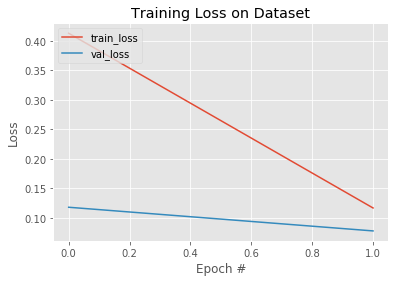

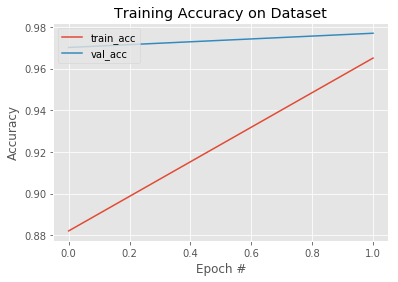

In [7]:
loss_list_plot = loss_list
val_loss_list_plot = val_loss_list
acc_list_plot = acc_list
val_acc_list_plot = val_acc_list

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
N = np.arange(0, len(loss_list_plot))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, loss_list_plot, label="train_loss")
plt.plot(N, val_loss_list_plot, label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
#plt.ylim(0, 0.10) # edit this line if needed to show a better graph
plt.show()

plt.figure()
plt.plot(N, acc_list_plot, label="train_acc")
plt.plot(N, val_acc_list_plot, label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
#plt.ylim(0.95, 1) # edit this line if needed to show a better graph
plt.show()

## LeNet2 with Antirectifier
Here we replace the first two ReLU activations with a new activation called "the Antirectifier". We also increase the number of filters for the second convolution layer and the size of the last two FC layers.

In [8]:
class Antirectifier(layers.Layer):
    def __init__(self, **kwargs):
        super(Antirectifier, self).__init__(**kwargs)

    def build(self, input_shape):
        output_dim = input_shape[-1]

    def call(self, inputs):
        inputs -= tf.reduce_mean(inputs, axis=-1, keepdims=True)
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        concatenated = tf.concat([pos, neg], axis=-1)
        return concatenated

    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(Antirectifier, self).get_config()
        return dict(list(base_config.items()))


In [9]:
K.clear_session()

class LeNet2:
  @staticmethod
  def build():
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (784,1)
    model.add(Input(shape=(784,)))
    model.add(Reshape((28, 28, 1), input_shape=(784,)))
    model.add(Conv2D(filters=6, kernel_size=(3, 3)))
    model.add(Antirectifier())
    model.add(AveragePooling2D())
    #model.add(Conv2D(filters=16, kernel_size=(3, 3)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3)))
    model.add(Antirectifier())
    model.add(AveragePooling2D())
    model.add(Flatten())
    #model.add(Dense(units=120))
    model.add(Dense(units=128))
    model.add(Activation("relu"))
    #model.add(Dense(units=84))
    model.add(Dense(units=128))
    model.add(Activation("relu"))
    model.add(Dense(units=10, activation = 'softmax'))
    return model

In [10]:
batch_size = 128
epochs = 30
init_lr = 1e-3
opt = Adam(lr=init_lr, decay=init_lr / (epochs * 0.5))
#checkpoint_filepath2 = '/content/checkpoint_LeNet2_{epoch:02d}_acc_{acc:.4f}_loss_{loss:.4f}_valacc_{val_acc:.4f}_valloss_{val_loss:.4f}.hdf5'
checkpoint_filepath2 = './content/checkpoint_LeNet2.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=False,
    monitor='val_acc', #val_accuracy in tf 2.0
    verbose=1,
    mode='max',
    save_best_only=False)

model2 = LeNet2.build()
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])
model2.summary()

#init_op = tf.global_variables_initializer()

#sess = tf.Session()
#sess.run(init_op)

# To clean the history of the training.
H2 = []
loss_list2 = []
val_loss_list2 = []
acc_list2 = []
val_acc_list2 = []

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
antirectifier (Antirectifier (None, 26, 26, 12)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        3488      
_________________________________________________________________
antirectifier_1 (Antirectifi (None, 11, 11, 64)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 64)          0

Let's train the new version of LeNet

In [11]:
H2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=2, callbacks=[model_checkpoint_callback], validation_split=0.1)

loss_list2 += H2.history['loss']
val_loss_list2 += H2.history['val_loss']
acc_list2 += H2.history['acc']
val_acc_list2 += H2.history['val_acc']

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
53888/54000 [============================>.] - ETA: 0s - loss: 0.2949 - acc: 0.9151
Epoch 00001: saving model to ./content/checkpoint_LeNet2.hdf5
54000/54000 [==============================] - 10s 181us/sample - loss: 0.2944 - acc: 0.9153 - val_loss: 0.0757 - val_acc: 0.9780
Epoch 2/2
53632/54000 [============================>.] - ETA: 0s - loss: 0.0817 - acc: 0.9749
Epoch 00002: saving model to ./content/checkpoint_LeNet2.hdf5
54000/54000 [==============================] - 10s 177us/sample - loss: 0.0816 - acc: 0.9749 - val_loss: 0.0862 - val_acc: 0.9750


In [12]:
# this is the score of the last epoch
score2 = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])

# reload best weights
model2.load_weights(checkpoint_filepath2)
score2 = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])

Test loss: 0.08101209335662425
Test accuracy: 0.9743
Test loss: 0.08101209335662425
Test accuracy: 0.9743


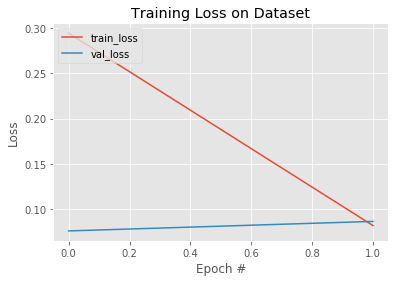

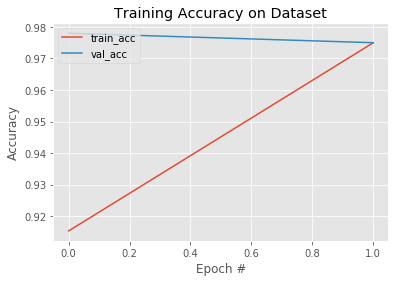

In [13]:
loss_list_plot = loss_list2
val_loss_list_plot = val_loss_list2
acc_list_plot = acc_list2
val_acc_list_plot = val_acc_list2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
N = np.arange(0, len(loss_list_plot))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, loss_list_plot, label="train_loss")
plt.plot(N, val_loss_list_plot, label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
#plt.ylim(0, 0.10) # edit this line if needed to show a better graph
plt.show()

plt.figure()
plt.plot(N, acc_list_plot, label="train_acc")
plt.plot(N, val_acc_list_plot, label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
#plt.ylim(0.95, 1) # edit this line if needed to show a better graph
plt.show()

## MLP
As the title says, we now try with a multilayer perceptron

In [14]:
K.clear_session()

class MLP:
  @staticmethod
  def build():
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (784,)
    model.add(Input(shape=(784,)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(Dense(10, activation="softmax"))
    return model

In [15]:
batch_size = 128
epochs = 30
init_lr = 1e-3
opt = Adam(lr=init_lr, decay=init_lr / (epochs * 0.5))
#checkpoint_filepath3 = '/content/checkpoint_MLP_{epoch:02d}_acc_{acc:.4f}_loss_{loss:.4f}_valacc_{val_acc:.4f}_valloss_{val_loss:.4f}.hdf5'
checkpoint_filepath3 = './content/checkpoint_MLP.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3,
    save_weights_only=False,
    monitor='val_acc', #val_accuracy in tf 2.0
    verbose=1,
    mode='max',
    save_best_only=False)

model3 = MLP.build()
model3.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])
model3.summary()

#init_op = tf.global_variables_initializer()

#sess = tf.Session()
#sess.run(init_op)

# To clean the history of the training.
H3 = []
loss_list3 = []
val_loss_list3 = []
acc_list3 = []
val_acc_list3 = []

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
__________________________________________________

In [16]:
H3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=2, callbacks=[model_checkpoint_callback], validation_split=0.1)

loss_list3 += H3.history['loss']
val_loss_list3 += H3.history['val_loss']
acc_list3 += H3.history['acc']
val_acc_list3 += H3.history['val_acc']

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
52608/54000 [============================>.] - ETA: 0s - loss: 0.2799 - acc: 0.9192
Epoch 00001: saving model to ./content/checkpoint_MLP.hdf5
54000/54000 [==============================] - 1s 21us/sample - loss: 0.2762 - acc: 0.9201 - val_loss: 0.1034 - val_acc: 0.9705
Epoch 2/2
52480/54000 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.9700
Epoch 00002: saving model to ./content/checkpoint_MLP.hdf5
54000/54000 [==============================] - 1s 20us/sample - loss: 0.1004 - acc: 0.9699 - val_loss: 0.0960 - val_acc: 0.9720


In [17]:
# this is the score of the last epoch
score3 = model3.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score3[0])
print("Test accuracy:", score3[1])

# reload best weights
model3.load_weights(checkpoint_filepath3)
score3 = model3.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score3[0])
print("Test accuracy:", score3[1])

Test loss: 0.10690669478587807
Test accuracy: 0.9683
Test loss: 0.10690669478587807
Test accuracy: 0.9683


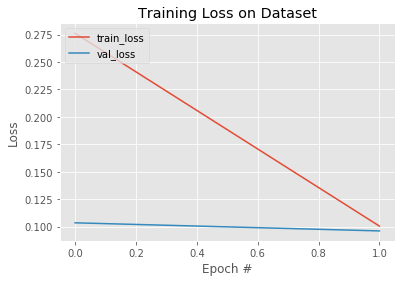

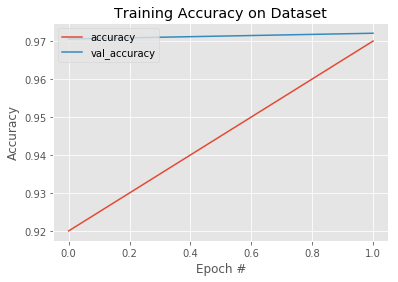

In [18]:
loss_list_plot = loss_list3
val_loss_list_plot = val_loss_list3
acc_list_plot = acc_list3
val_acc_list_plot = val_acc_list3

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
N = np.arange(0, len(loss_list_plot))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, loss_list_plot, label="train_loss")
plt.plot(N, val_loss_list_plot, label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
#plt.ylim(0, 0.10) # edit this line if needed to show a better graph
plt.show()

plt.figure()
plt.plot(N, acc_list_plot, label="accuracy")
plt.plot(N, val_acc_list_plot, label="val_accuracy")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
#plt.ylim(0.95, 1) # edit this line if needed to show a better graph
plt.show()

## The Mini CNN
Finally, we use a small CNN with very few parameters and an Antirectifier as activation function. Let's see if it can compete with the previous networks.

In [19]:
K.clear_session()

class MINICNN:
  @staticmethod
  def build():
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (784,1)
    model.add(Input(shape=(784,)))
    model.add(Reshape((28, 28, 1), input_shape=(784,)))
    model.add(Conv2D(16, kernel_size=(3, 3)))
    model.add(Antirectifier())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3)))
    model.add(Antirectifier())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="softmax"))
    return model

In [20]:
batch_size = 128
epochs = 30
init_lr = 1e-3
opt = Adam(lr=init_lr, decay=init_lr / (epochs * 0.5))
#checkpoint_filepath4 = '/content/checkpoint_MINICNN_{epoch:02d}_acc_{acc:.4f}_loss_{loss:.4f}_valacc_{val_acc:.4f}_valloss_{val_loss:.4f}.hdf5'
checkpoint_filepath4 = './content/checkpoint_MINICNN.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath4,
    save_weights_only=False,
    monitor='val_acc', #val_accuracy in tf 2.0
    verbose=1,
    mode='max',
    save_best_only=False)

model4 = MINICNN.build()
model4.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])
model4.summary()

#init_op = tf.global_variables_initializer()

#sess = tf.Session()
#sess.run(init_op)

# To clean the history of the training.
H4 = []
loss_list4 = []
val_loss_list4 = []
acc_list4 = []
val_acc_list4 = []

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
antirectifier (Antirectifier (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
antirectifier_1 (Antirectifi (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

In [21]:
H4 = model4.fit(x_train, y_train, batch_size=batch_size, epochs=2, callbacks=[model_checkpoint_callback], validation_split=0.1)

loss_list4 += H4.history['loss']
val_loss_list4 += H4.history['val_loss']
acc_list4 += H4.history['acc']
val_acc_list4 += H4.history['val_acc']

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
53888/54000 [============================>.] - ETA: 0s - loss: 0.3783 - acc: 0.8859
Epoch 00001: saving model to ./content/checkpoint_MINICNN.hdf5
54000/54000 [==============================] - 15s 280us/sample - loss: 0.3778 - acc: 0.8860 - val_loss: 0.0903 - val_acc: 0.9750
Epoch 2/2
53888/54000 [============================>.] - ETA: 0s - loss: 0.1308 - acc: 0.9591
Epoch 00002: saving model to ./content/checkpoint_MINICNN.hdf5
54000/54000 [==============================] - 15s 276us/sample - loss: 0.1306 - acc: 0.9591 - val_loss: 0.0647 - val_acc: 0.9812


In [22]:
# this is the score of the last epoch
score4 = model4.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score4[0])
print("Test accuracy:", score4[1])

# reload best weights
model4.load_weights(checkpoint_filepath4)
score4 = model4.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score4[0])
print("Test accuracy:", score4[1])

Test loss: 0.06029439311167225
Test accuracy: 0.9814
Test loss: 0.06029439311167225
Test accuracy: 0.9814


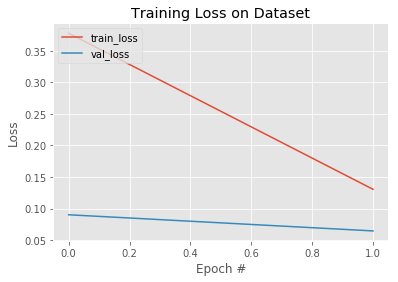

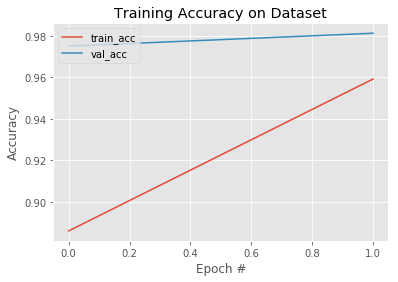

In [23]:
loss_list_plot = loss_list4
val_loss_list_plot = val_loss_list4
acc_list_plot = acc_list4
val_acc_list_plot = val_acc_list4

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
N = np.arange(0, len(loss_list_plot))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, loss_list_plot, label="train_loss")
plt.plot(N, val_loss_list_plot, label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
#plt.ylim(0, 0.10) # edit this line if needed to show a better graph
plt.show()

plt.figure()
plt.plot(N, acc_list_plot, label="train_acc")
plt.plot(N, val_acc_list_plot, label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
#plt.ylim(0.95, 1) # edit this line if needed to show a better graph
plt.show()

# Export the final solution
After selecting your final implementation of the network for MNIST classification, here you can export its frozen graph.

## Export LeNet2
Load the model checkpoint and freeze the graph

In [24]:
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                print(node)
                node.device = ""
        print(output_names)
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

from tensorflow.keras import backend as K

# This line must be executed before loading Keras model.
# If you use dropout, batch normalization or any other layers like these
# (which have not trainable but calculating values),
# you should change the learning phase of keras backend
K.set_learning_phase(0) # 0 testing, 1 training mode
frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model4.outputs])

name: "keras_learning_phase/input"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_BOOL
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_BOOL
      tensor_shape {
      }
      bool_val: false
    }
  }
}

name: "keras_learning_phase"
op: "PlaceholderWithDefault"
input: "keras_learning_phase/input"
attr {
  key: "dtype"
  value {
    type: DT_BOOL
  }
}
attr {
  key: "shape"
  value {
    shape {
    }
  }
}

name: "input_1"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: 784
      }
    }
  }
}

name: "reshape/Shape"
op: "Shape"
input: "input_1"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "out_type"
  value {
    type: DT_INT32
  }
}

name: "reshape/strided_slice/stack"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32


In [25]:
tf.train.write_graph(frozen_graph, "model", "tf_model_MNIST.pb", as_text=False)
tf.train.write_graph(frozen_graph, "model", "tf_model_MNIST.pbtxt", as_text=True)

'model/tf_model_MNIST.pbtxt'

## Download and edit LeNet2 graph
On the left of this notebook, click on the files icon and browse the "model" folder. It should now contain two files, "tf_model_MNIST.pb" and "tf_model_MNIST.pbtxt". Right click on both of them and download them on your computer.

Now open the .pbtxt file with an editor (emacs is recommended because it can handle quite well large files) and look for the first occurrence of the "antirectifier". You will find a part of the frozen graph that corresponds to the various operations of the antirectifier layer:
```
node {
  name: "antirectifier/Mean/reduction_indices"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: -1
      }
    }
  }
}
node {
  name: "antirectifier/Mean"
  op: "Mean"
  input: "conv2d/BiasAdd"
  input: "antirectifier/Mean/reduction_indices"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "Tidx"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "keep_dims"
    value {
      b: true
    }
  }
}
node {
  name: "antirectifier/sub"
  op: "Sub"
  input: "conv2d/BiasAdd"
  input: "antirectifier/Mean"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "antirectifier/Relu"
  op: "Relu"
  input: "antirectifier/sub"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "antirectifier/Neg"
  op: "Neg"
  input: "antirectifier/sub"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "antirectifier/Relu_1"
  op: "Relu"
  input: "antirectifier/Neg"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "antirectifier/concat/axis"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: -1
      }
    }
  }
}
node {
  name: "antirectifier/concat"
  op: "ConcatV2"
  input: "antirectifier/Relu"
  input: "antirectifier/Relu_1"
  input: "antirectifier/concat/axis"
  attr {
    key: "N"
    value {
      i: 2
    }
  }
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "Tidx"
    value {
      type: DT_INT32
    }
  }
}
```
The goal now is to pass the frozen graph to OpenVINO's model optimizer. However, we don't want that all those operations are mapped to their equivalent OpenVINO operation: we want instead to have our own version of the Antirectifier described with a new OpenCL code. Therefore, we need to replace the entire block above with a simple node as follows:

```
node {
  name: "antirectifier"
  op: "Antirectifier"
  input: "conv2d/BiasAdd"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
```
In this case, the input to the antirectifier block comes from ``"conv2d/BiasAdd"`` in the frozen graph. In your case, you should look for which node is the input and use that node instead of what we used here. Another change is related to the node that receives the output of the Antirectifier as an input. In this case, the following node
```
node {
  name: "average_pooling2d/AvgPool"
  op: "AvgPool"
  input: "antirectifier/concat"
  ...
```
must be replaced as follows
```
node {
  name: "average_pooling2d/AvgPool"
  op: "AvgPool"
  input: "antirectifier"
  ...
```
because we would have replaced all the internal nodes of the antirectifier with a single node.
In this network (and possibly in your network too) there are different occurences of the antirectifier. Each block of nodes must be replaces accordingly. In this case, the following block of nodes (shortened)
```
node {
  name: "antirectifier_1/Mean/reduction_indices"
  op: "Const"
...
node {
  name: "antirectifier_1/concat"
  op: "ConcatV2"
...
```
must be ALL replaced with a single node as follows:
```
node {
  name: "antirectifier_1"
  op: "Antirectifier"
  input: "conv2d_1/BiasAdd"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
```
and the node that receives the second antirectifier, which is the following
```
node {
  name: "average_pooling2d_1/AvgPool"
  op: "AvgPool"
  input: "antirectifier_1/concat"
  ...
```
should be changed as follows
```
node {
  name: "average_pooling2d_1/AvgPool"
  op: "AvgPool"
  input: "antirectifier_1"
  ...
```
Repeat the same replacement procedure for any other occurrence of the antirectifier in your network.

# Now it's up to you
Create a new network and try to make it competitive with the previous ones, either more accurate and bigger (i.e. more layers and more parameters) or less accurate but smaller. See the slides "Lab 1: MNIST Competition" for more information and to know the constraints of the contest.

###Your network
Write your own network and give it a name. Use AntiRectifier as activation.

In [26]:
K.clear_session()

class YourNet:
  @staticmethod
  def build():
    model = Sequential()
    inputShape = (784,1)
    model.add(Input(shape=(784,)))
    model.add(Reshape((28, 28, 1), input_shape=(784,)))

    # ...

    model.add(Dense(units=10, activation = 'softmax'))
    return model

##Your training
Remember that for the contest the number of epochs is fixed to 30 and can't be changed. All the other hyper-parameters, such as batch_size, init_lr, opt, etc., can be edited.

In [27]:
batch_size = 128
epochs = 30
init_lr = 1e-3
opt = Adam(lr=init_lr, decay=init_lr / (epochs * 0.5))
#checkpoint_filepath5 = '/content/checkpoint_YourNet_{epoch:02d}_acc_{acc:.4f}_loss_{loss:.4f}_valacc_{val_acc:.4f}_valloss_{val_loss:.4f}.hdf5'
checkpoint_filepath5 = '/content/checkpoint_YourNet.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath5,
    save_weights_only=False,
    monitor='val_acc', #val_accuracy in tf 2.0
    verbose=1,
    mode='max',
    save_best_only=True)

model5 = YourNet.build()
model5.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])
model5.summary()

#init_op = tf.global_variables_initializer()

#sess = tf.Session()
#sess.run(init_op)

# To clean the history of the training.
H5 = []
loss_list5 = []
val_loss_list5 = []
acc_list5 = []
val_acc_list5 = []

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
dense (Dense)                (None, 28, 28, 10)        20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [28]:
H5 = model5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[model_checkpoint_callback], validation_split=0.1)

loss_list5 += H5.history['loss']
val_loss_list5 += H5.history['val_loss']
acc_list5 += H5.history['acc']
val_acc_list5 += H5.history['val_acc']

ValueError: A target array with shape (60000, 10) was passed for an output of shape (None, 28, 28, 10) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

In [ ]:
# this is the score of the last epoch
score5 = model5.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score5[0])
print("Test accuracy:", score5[1])

# reload best weights
model5.load_weights(checkpoint_filepath5)
score5 = model5.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score5[0])
print("Test accuracy:", score5[1])

In [ ]:
loss_list_plot = loss_list5
val_loss_list_plot = val_loss_list5
acc_list_plot = acc_list5
val_acc_list_plot = val_acc_list5

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
N = np.arange(0, len(loss_list_plot))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, loss_list_plot, label="train_loss")
plt.plot(N, val_loss_list_plot, label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.ylim(0, 0.90) # edit this line if needed to show a better graph
plt.show()

plt.figure()
plt.plot(N, acc_list_plot, label="train_acc")
plt.plot(N, val_acc_list_plot, label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.ylim(0.0, 1) # edit this line if needed to show a better graph
plt.show()

## Export your model
Repeate the previous steps for your model.

In [ ]:
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

from tensorflow.keras import backend as K

# This line must be executed before loading Keras model.
# If you use dropout, batch normalization or any other layers like these
# (which have not trainable but calculating values),
# you should change the learning phase of keras backend
K.set_learning_phase(0) # 0 testing, 1 training mode

frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model5.outputs])

In [ ]:
tf.train.write_graph(frozen_graph, "model5", "tf_model5_MNIST.pb", as_text=False)
tf.train.write_graph(frozen_graph, "model5", "tf_model5_MNIST.pbtxt", as_text=True)

## Download and edit your graph
Repeat the same replacement procedure for any other occurrence of the antirectifier in your network